In [1]:
import warnings
import os
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

In [2]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, regularizers, optimizers
from tensorflow.keras.callbacks import Callback
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
import pickle
import librosa
import random
import glob
import soundfile as sf
import pandas as pd
from tqdm import tqdm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense

In [3]:
# gpus = tf.config.experimental.list_physical_devices('GPU')
# if gpus:
#     try:
#         for gpu in gpus:
#             tf.config.experimental.set_memory_growth(gpu, True)
#     except RuntimeError as e:
#         print(e)

## Speaker Verification

### Loading and Processing Data

In [6]:
with open('trs.pkl', 'rb') as f:
    train_data = pickle.load(f)
with open('tes.pkl', 'rb') as f:
    test_data = pickle.load(f)

In [8]:
def compute_stft(audio_data):
    # STFT
    stft = librosa.stft(audio_data, n_fft=1024, hop_length=512)
    # magnitude spectrum
    magnitude = np.abs(stft)
    # Log-scale
    magnitude = np.log1p(magnitude)
    magnitude = (magnitude - np.mean(magnitude)) / (np.std(magnitude) + 1e-8)
    return magnitude.T  # shape: (T, 513)

In [9]:
def create_minibatch(data, speaker_idx, utterances_per_speaker=10, L=45):
    # current speaker's utterances
    start_idx = speaker_idx * utterances_per_speaker
    end_idx = start_idx + utterances_per_speaker
    speaker_data = data[start_idx:end_idx]
    
    # L positive pairs
    positive_pairs = []
    for _ in range(L):
        idx1, idx2 = np.random.choice(utterances_per_speaker, size=2, replace=True)
        positive_pairs.append([speaker_data[idx1], speaker_data[idx2]])
    
    # L negative pairs
    negative_pairs = []
    other_speakers_indices = list(range(0, start_idx)) + list(range(end_idx, len(data)))
    
    # L utterances from other speakers
    other_indices = np.random.choice(other_speakers_indices, size=L, replace=False)
    # L utterances from current speaker
    current_indices = np.random.choice(utterances_per_speaker, size=L, replace=True)
    
    # negative pairs
    for i in range(L):
        current_utterance = speaker_data[current_indices[i]]
        other_utterance = data[other_indices[i]]
        negative_pairs.append([current_utterance, other_utterance])
    
    all_pairs = positive_pairs + negative_pairs
    all_labels = [1] * L + [0] * L
    combined = list(zip(all_pairs, all_labels))
    random.shuffle(combined)
    all_pairs, all_labels = zip(*combined)
    
    return np.array(all_pairs), np.array(all_labels)

In [10]:
def process_minibatch(pairs):
    processed_pairs = []
    for pair in pairs:
        # STFT for both utterances in the pair
        spec1 = compute_stft(pair[0])
        spec2 = compute_stft(pair[1])
        processed_pairs.append([spec1, spec2])
    return np.array(processed_pairs)

### Siamese Network

In [11]:
class SiameseNetwork(tf.keras.Model):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        # GRU layers
        self.gru1 = tf.keras.layers.GRU(256, return_sequences=True)
        self.gru2 = tf.keras.layers.GRU(128, return_sequences=True)
        self.gru3 = tf.keras.layers.GRU(64)
        
        # Dense layers with regularization
        self.batch_norm1 = tf.keras.layers.BatchNormalization()
        self.dense1 = tf.keras.layers.Dense(128, activation='relu')
        self.dropout1 = tf.keras.layers.Dropout(0.3)
        self.batch_norm2 = tf.keras.layers.BatchNormalization()
        self.dense2 = tf.keras.layers.Dense(64)
        
    def get_embedding(self, x):
        # Input shape: (batch_size, 513, T)
        x = self.gru1(x)
        x = self.gru2(x)
        x = self.gru3(x)
        x = self.batch_norm1(x)
        x = self.dense1(x)
        x = self.dropout1(x)
        x = self.batch_norm2(x)
        return self.dense2(x)
    
    def call(self, inputs):
        input1, input2 = inputs
        embedding1 = self.get_embedding(input1)
        embedding2 = self.get_embedding(input2)
        similarity = tf.reduce_sum(embedding1 * embedding2, axis=1)
        return tf.sigmoid(similarity)

In [12]:
def train_model(model, train_data, test_data, num_speakers=50, utterances_per_speaker=10, 
                L=45, epochs=30, batch_size=32):
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    loss_fn = tf.keras.losses.BinaryCrossentropy()
    
    train_accuracies = []
    test_accuracies = []
    
    for epoch in range(epochs):
        total_loss = 0
        total_accuracy = 0
        
        # train on each speaker's minibatch
        for speaker in range(num_speakers):
            # create and process minibatch
            pairs, labels = create_minibatch(train_data, speaker, utterances_per_speaker, L)
            processed_pairs = process_minibatch(pairs)

            spec1 = tf.convert_to_tensor(processed_pairs[:, 0], dtype=tf.float32)
            spec2 = tf.convert_to_tensor(processed_pairs[:, 1], dtype=tf.float32)
            labels = tf.convert_to_tensor(labels, dtype=tf.float32)
            
            with tf.GradientTape() as tape:
                predictions = model([spec1, spec2])
                loss = loss_fn(labels, predictions)
            
            gradients = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))
            
            total_loss += loss
            accuracy = tf.reduce_mean(tf.cast(tf.round(predictions) == labels, tf.float32))
            total_accuracy += accuracy
        
        # average training metrics
        avg_loss = total_loss / num_speakers
        avg_train_accuracy = total_accuracy / num_speakers
        train_accuracies.append(avg_train_accuracy)
        
        # evaluate on test set
        test_accuracy = evaluate_model(model, test_data, 20, utterances_per_speaker, L)
        test_accuracies.append(test_accuracy)
        
        print(f"Epoch {epoch+1}/{epochs}")
        print(f"Loss: {avg_loss:.4f}")
        print(f"Training Accuracy: {avg_train_accuracy:.4f}")
        print(f"Test Accuracy: {test_accuracy:.4f}")
        print("-" * 50)
    
    plt.figure(figsize=(10, 6))
    plt.plot(train_accuracies, label='Train')
    plt.plot(test_accuracies, label='Test')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return test_accuracies[-1]

### Test Accuracy

In [16]:
def evaluate_model(model, test_data, num_speakers, utterances_per_speaker, L):
    total_accuracy = 0
    
    for speaker in range(num_speakers):
        pairs, labels = create_minibatch(test_data, speaker, utterances_per_speaker, L)
        processed_pairs = process_minibatch(pairs)
        
        spec1 = tf.convert_to_tensor(processed_pairs[:, 0], dtype=tf.float32)
        spec2 = tf.convert_to_tensor(processed_pairs[:, 1], dtype=tf.float32)
        labels = tf.convert_to_tensor(labels, dtype=tf.float32)
        
        predictions = model([spec1, spec2])
        accuracy = tf.reduce_mean(tf.cast(tf.round(predictions) == labels, tf.float32))
        total_accuracy += accuracy
        
    # average accuracy across all speakers in the test set
    return total_accuracy / num_speakers

Epoch 1/30
Loss: 0.6791
Training Accuracy: 0.5911
Test Accuracy: 0.5911
--------------------------------------------------
Epoch 2/30
Loss: 0.6434
Training Accuracy: 0.6389
Test Accuracy: 0.5861
--------------------------------------------------
Epoch 3/30
Loss: 0.6142
Training Accuracy: 0.6864
Test Accuracy: 0.6572
--------------------------------------------------
Epoch 4/30
Loss: 0.5811
Training Accuracy: 0.7227
Test Accuracy: 0.7317
--------------------------------------------------
Epoch 5/30
Loss: 0.5556
Training Accuracy: 0.7416
Test Accuracy: 0.7189
--------------------------------------------------
Epoch 6/30
Loss: 0.5676
Training Accuracy: 0.7411
Test Accuracy: 0.7278
--------------------------------------------------
Epoch 7/30
Loss: 0.5304
Training Accuracy: 0.7802
Test Accuracy: 0.7467
--------------------------------------------------
Epoch 8/30
Loss: 0.5437
Training Accuracy: 0.7620
Test Accuracy: 0.7394
--------------------------------------------------
Epoch 9/30
Loss:

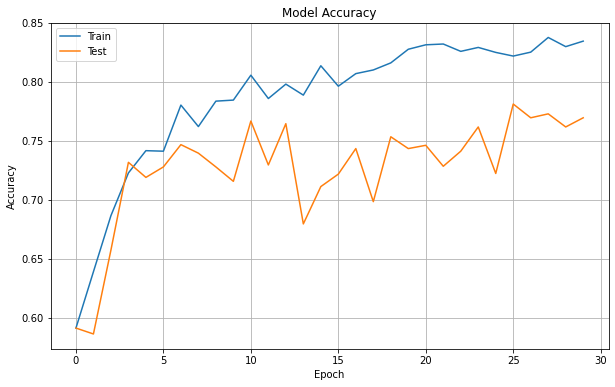


Final Test Accuracy: 76.94%


In [17]:
# Create and train model
model = SiameseNetwork()
final_accuracy = train_model(
    model, 
    train_data, 
    test_data,
    L=45,
    epochs=30,
    batch_size=32
)

print(f"\nFinal Test Accuracy: {final_accuracy*100:.2f}%")